# Análisis exploratorio inicial y baselines

### Principales insights

* El 30% de los productos comprados aparecen en el historial.

* El ndcg baseline fue 0.20850. Consiste en tomar el historial de visitas en orden temporal (más reciente más importante), rellenando con productos más visitados.

In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter

## Revisa si existe algún producto que tienen un evento view antes de ser comprado

In [2]:
viewed_count = 0
line_idx = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1 
        data = json.loads(line)
        viewed_count += data["item_bought"] in set([event["event_info"] for event in data["user_history"] if event["event_type"] == "view"])

In [3]:
print(f"Proporción de productos vistos {viewed_count *100 / line_idx:.2f}%")

Proporción de productos vistos 29.39%


## Revisa si el historial está ordenado

El historial está ordenado por fecha de forma creciente

In [4]:
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        last_event_time = "0"
        for event in data["user_history"]:
            assert(last_event_time <= event['event_timestamp']) 
            last_event_time = event['event_timestamp']

In [5]:
with open("./data/test_dataset.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        last_event_time = "0"
        for event in data["user_history"]:
            assert(last_event_time <= event['event_timestamp']) 
            last_event_time = event['event_timestamp']

No se diferencian las fechas por timezone

In [6]:
time_offset_counter = Counter()
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        time_offset_counter.update(set([event['event_timestamp'][-5:] for event in data["user_history"]]))
            


In [7]:
time_offset_counter

Counter({'-0400': 413163})

## Productos comprados más populares

In [12]:
items_bought = Counter()
line_idx = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1 
        data = json.loads(line)
        items_bought[data["item_bought"]] += 1
        

In [13]:
print(f"Total productos comprados: {len(items_bought):,d}")

Total productos comprados: 64,928


In [14]:
df_items_bought = pd.DataFrame(items_bought.most_common(), columns=["item", "freq"])
df_items_bought["density"] = df_items_bought.freq / df_items_bought.freq.sum()

No existen items muy populares. El más popular representa el 0.1% de los casos

In [15]:
df_items_bought.head(10)

,item,freq,density
0,1587422,558,0.001351
1,1803710,384,0.000929
2,10243,371,0.000898
3,548905,348,0.000842
4,1906937,344,0.000833
5,716822,330,0.000799
6,1361154,326,0.000789
7,1716388,324,0.000784
8,725371,322,0.000779
9,859574,322,0.000779


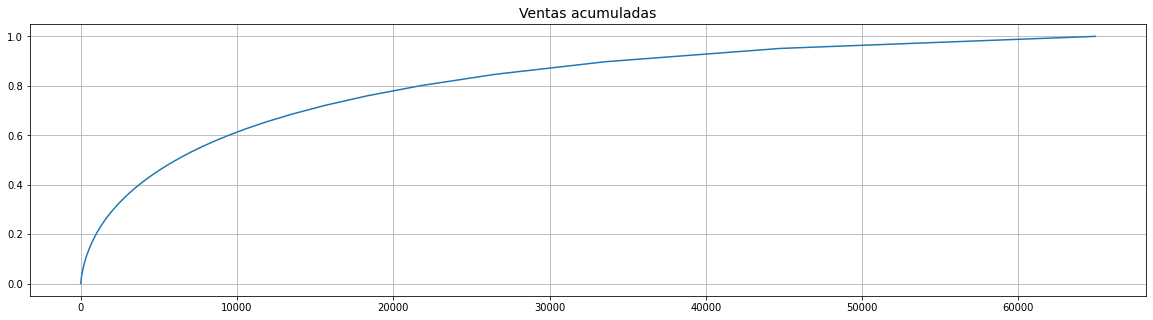

In [16]:
ax = df_items_bought.density.cumsum().plot(grid=True, figsize=(20,5));
ax.set_title("Ventas acumuladas", fontsize=14);

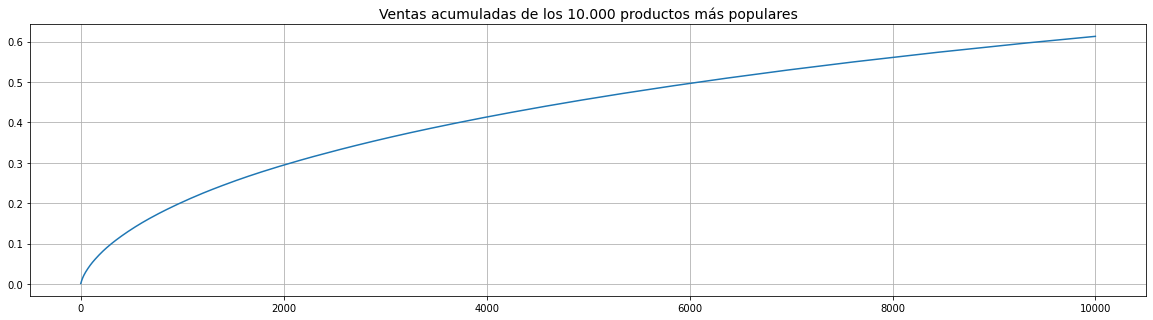

In [17]:
ax = df_items_bought.density.cumsum()[:10000].plot(grid=True, figsize=(20,5));
ax.set_title("Ventas acumuladas de los 10.000 productos más populares", fontsize=14);

## Productos más visitados

In [18]:
items_pv = Counter()
items_unique_users = Counter()
line_idx = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1
        data = json.loads(line)
        view = [event["event_info"] for event in data["user_history"] if event["event_type"] == "view"]
        items_pv.update(view)
        items_unique_users.update(set(view))

In [19]:
print(f"Total productos visitados: {len(items_pv):,d}")

Total productos visitados: 1,601,277


In [20]:
df_items_view = (
    pd.DataFrame(items_unique_users.most_common(), columns=["item", "users"]).merge(
        pd.DataFrame(items_pv.most_common(), columns=["item", "views"]),
        on="item")
    )

In [21]:
df_items_view.head(10)

,item,users,views
0,1587422,2054,5094
1,849156,1346,3289
2,10243,926,2598
3,1716388,920,2265
4,1361154,917,2522
5,882697,832,2506
6,1803710,829,2928
7,119703,786,2000
8,1371799,700,1910
9,716822,679,2212


In [22]:
df_items_bought.head(10)

,item,freq,density
0,1587422,558,0.001351
1,1803710,384,0.000929
2,10243,371,0.000898
3,548905,348,0.000842
4,1906937,344,0.000833
5,716822,330,0.000799
6,1361154,326,0.000789
7,1716388,324,0.000784
8,725371,322,0.000779
9,859574,322,0.000779


## Productos de catálogo

En el dominio o la categoría se codifica el país

In [23]:
category_count = Counter()
domain_count = Counter()
country_count = Counter()
items_count = 0
domain_null_count = 0
with open("./data/item_data.jl", "rt") as fd:
    for line in fd:
        items_count += 1
        data = json.loads(line)
        category_count[data["category_id"]] += 1
        domain_count[data["domain_id"]] += 1
        if data["domain_id"] == None:
            domain_null_count += 1
               
        country_count[data["category_id"][:3]] += 1


In [24]:
data

{'item_id': 2010306,
 'title': 'Kit Turbo Turbina Virtual Simulador Som Apito Carro E Moto',
 'domain_id': 'MLB-VEHICLE_ACCESSORIES',
 'product_id': None,
 'price': '64.99',
 'category_id': 'MLB117639',
 'condition': 'new'}

In [25]:
print(f"Total productos catálogo: {items_count:,d}")
print(f"Total categorías: {len(category_count):,d}")
print(f"Total dominios: {len(domain_count):,d}")
print(f"Productos sin dominios: {domain_null_count:,d}")

Total productos catálogo: 2,102,277
Total categorías: 11,493
Total dominios: 7,894
Productos sin dominios: 851


La mayoría de los productos son Brasileños

In [26]:
country_count.most_common(2)

[('MLB', 1723826), ('MLM', 378451)]

In [27]:
domain_count.most_common(10)

[('MLB-CARS_AND_VANS', 41420),
 ('MLB-CELLPHONES', 38390),
 ('MLB-SNEAKERS', 32636),
 ('MLB-VEHICLE_ACCESSORIES', 28986),
 ('MLB-T_SHIRTS', 23823),
 ('MLB-SUPPLEMENTS', 22351),
 ('MLB-DRESSES', 21590),
 ('MLB-VEHICLE_PARTS', 18727),
 ('MLB-SANDALS_AND_FLIP_FLOPS', 15102),
 ('MLM-CARS_AND_VANS', 14165)]

In [28]:
category_count.most_common(10)

[('MLB1744', 41204),
 ('MLB1055', 38390),
 ('MLB23332', 31204),
 ('MLB31447', 23653),
 ('MLB108704', 20703),
 ('MLB122102', 17821),
 ('MLB273770', 15102),
 ('MLM1744', 14144),
 ('MLB1839', 13596),
 ('MLB32130', 13441)]

Índices de dominios

In [30]:
domain_to_index = {domain_id: index for index, (domain_id, _) in enumerate(domain_count.most_common())}

In [31]:
item_id_to_domain_idx = {}
with open("./data/item_data.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        item_id_to_domain_idx[data["item_id"]] = domain_to_index[data["domain_id"]]

## Compras según catálogo

In [32]:
catalog = {}
with open("./data/item_data.jl", "rt") as fd:
    for line in fd:
        items_count += 1
        data = json.loads(line)
        item_id = data.pop("item_id")
        catalog[item_id] = data

In [34]:
data

{'title': 'Kit Turbo Turbina Virtual Simulador Som Apito Carro E Moto',
 'domain_id': 'MLB-VEHICLE_ACCESSORIES',
 'product_id': None,
 'price': '64.99',
 'category_id': 'MLB117639',
 'condition': 'new'}

In [37]:
condition_count = Counter()
used_top_sales = Counter()
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1
        data = json.loads(line)
        bought = data["item_bought"]
        condition = catalog[bought]["condition"]
        condition_count[condition] += 1
        if condition == 'used':
            used_top_sales[bought] += 1

Muy pocos productos usados son comprados

In [38]:
condition_count.most_common()

[('new', 412637), ('used', 411), ('not_specified', 115)]

Los proudctos usados suelen venderse más de una vez

In [39]:
used_top_sales.most_common(10)

[(1352725, 39),
 (947444, 21),
 (254797, 16),
 (1860643, 16),
 (275235, 15),
 (1378614, 13),
 (1994583, 12),
 (1295086, 12),
 (1497812, 10),
 (1337002, 10)]

In [84]:
catalog[1352725]

{'title': 'Recarga De Telcel De $100 A Solo $80',
 'domain_id': 'MLM-UNCLASSIFIED_PRODUCTS',
 'product_id': None,
 'price': '80.00',
 'category_id': 'MLM3530',
 'condition': 'used'}

La mayoría de los productos no tiene un product_id

In [41]:
Counter([item["product_id"] for item in catalog.values()]).most_common(10)

[(None, 1805749),
 ('14141079', 1361),
 ('15047011', 899),
 ('13527776', 846),
 ('14906502', 648),
 ('15283837', 575),
 ('14786768', 571),
 ('14482698', 540),
 ('13841392', 532),
 ('15188551', 515)]

In [43]:
condition_count = Counter()
sales_with_product_id = 0

total_sales = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        bought = data["item_bought"]
        if catalog[bought]["product_id"]:
            sales_with_product_id += 1        
        total_sales += 1

In [44]:
products_with_product_id = 0
for item in catalog.values():
    if item["product_id"]:
        products_with_product_id += 1

La proporción del productos con atributo product_id es mayor en las ventas que en el catálogo.

In [46]:
sales_with_product_id / total_sales, products_with_product_id / len(catalog)

(0.26018060668549703, 0.14105087008039377)

¿Todos los productos tienen precio?

In [116]:
products_with_price = 0
for item in catalog.values():
    if item["price"] != None:
        float(item["price"])
        products_with_price += 1

La mayoría de los productos tienen precio

In [117]:
products_with_price / len(catalog), len(catalog) - products_with_price

(0.9998387462736833, 339)

De los que no tienen precio, ninguno se vendió

In [47]:
condition_count = Counter()
sales_no_price = 0
views_no_price = 0
total_sales = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        data = json.loads(line)
        bought = data["item_bought"]
        sales_no_price += 1 if catalog[bought]["price"] == None else 0
        views = set([event["event_info"] for event in data["user_history"] if event["event_type"] == "view"])
        
        views_no_price += len([1 for item in views if catalog[item]["price"] == None])
        total_sales += 1

In [120]:
sales_no_price

0

Pero la mayoría tuvo visitas

In [49]:
views_no_price

313

Tampoco se vendieron productos sin dominio

In [50]:

sales_without_domain_id = 0
views_without_domain_id = 0

total_sales = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        
        data = json.loads(line)
        bought = data["item_bought"]
        sales_without_domain_id += 1 if catalog[bought]["domain_id"] == None else 0
        views = set([event["event_info"] for event in data["user_history"] if event["event_type"] == "view"])
        
        views_without_domain_id += len([1 for item in views if catalog[item]["domain_id"] == None])
        total_sales += 1

In [51]:
sales_without_domain_id

0

In [52]:
views_without_domain_id

769

Todos los productos tienen título

In [53]:
len([1 for item in catalog.values() if len(item["title"]) == 0]) == 0

True

Algunos tienen títulos muy cortos

In [54]:
[item["title"] for item in catalog.values() if len(item["title"]) < 2 ]

['D', 'X', 'L', '%', '¿', 'U', '.', 'C', 'C', '.', 'J', 'A', 'R', '¿', ',']

Si el título es muy chico la probabilidad de compra es muy baja

In [55]:
len([1 for item_id, item in catalog.items() if len(item["title"]) < 10 and items_bought[item_id] > 0]) / \
len([1 for item_id, item in catalog.items() if len(item["title"]) < 10])

0.007273580478648522

En comparación, la proporción de productos con ventas en todo el catálogo es de un 3%

In [58]:
len(items_bought) / len(catalog)

0.030884607499392324

La mayoría tuvieron visitas, aunque en menor proporción al resto del catálogo

In [61]:
len([1 for item_id, item in catalog.items() if len(item["title"]) < 10 and items_pv[item_id] > 0]) / \
len([1 for item_id, item in catalog.items() if len(item["title"]) < 10])

0.7430783669638668

In [62]:
len(items_pv) / len(catalog)

0.7616869708416161

## Búsquedas

In [63]:
line_idx = 0

search_pv = Counter()
search_unique_users = Counter()
line_idx = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1
        data = json.loads(line)
        searchs = [event["event_info"] for event in data["user_history"] if event["event_type"] == "search"]
        search_pv.update(searchs)
        search_unique_users.update(set(searchs))

In [64]:
print(f"Total búsquedas únicas: {len(search_pv):,d}")

Total búsquedas únicas: 848,455


In [65]:
df_searchs = (
    pd.DataFrame(search_unique_users.most_common(), columns=["seach", "users"]).merge(
        pd.DataFrame(search_pv.most_common(), columns=["seach", "views"]),
        on="seach")
    )

In [66]:
df_searchs.head(10)

,seach,users,views
0,TENIS MASCULINO,2317,20689
1,CELULAR,2220,13005
2,CELULAR XIAOMI,2010,10358
3,RELOGIO SMARTWATCH,1908,12469
4,XIAOMU,1759,8109
5,FONE BLUETOOTH,1716,10299
6,BEBE REBORN,1590,16877
7,REDMI NOTE 7,1586,7747
8,TENIS FEMININO,1539,12199
9,MI BAND 4,1505,8430


In [67]:
df_searchs.tail(10)

,seach,users,views
848445,LANIX ILIUM X510,1,4
848446,FLEXI COUNTRY VIEJOS,1,3
848447,ZAPATOS FLEXI COUNTRY CABALLERO,1,4
848448,XIAOMI REDMI 7A 16GB AZUL,1,1
848449,BATERIA SUBURBAN EQUIVALENTE 17 CAPAS GUNNER,1,2
848450,BATERIA GONHER 17 PLACAS,1,2
848451,ZAPATOS FLEXI HOMBRE ANTIGUOS,1,3
848452,ZAPATOS FLEXI RETRO,1,3
848453,ALUGUEL BOB CAT,1,1
848454,COTONETE FINO,1,1


Me sorprende que sólo un ser humano estuvo interesado en cotonetes finos

## Sesiones

In [68]:
line_idx = 0

rows = []
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        line_idx += 1
        data = json.loads(line)
        nevents = len(data['user_history'])
        nsearchs = len([event["event_info"] for event in data["user_history"] if event["event_type"] == "search"])
        nviews = nevents - nsearchs
        ti = data['user_history'][0]['event_timestamp']
        tf = data['user_history'][-1]['event_timestamp']
        rows.append([nevents, nsearchs, nviews, ti, tf])
        

In [69]:
data['user_history'][0]['event_timestamp']

'2019-10-01T20:13:11.202-0400'

In [70]:
df_sessions = pd.DataFrame(rows, columns=["nevents", "nsearchs", "nviews", "first_event", "last_event"])
df_sessions["first_event"] = pd.to_datetime(df_sessions.first_event)
df_sessions["last_event"] = pd.to_datetime(df_sessions.last_event)
df_sessions["rel_searchs"] = df_sessions.nsearchs / df_sessions.nevents

In [71]:
df_sessions["duration"] = (df_sessions.last_event - df_sessions.first_event)

Las sesiones suelen tener tantas búsquedas como visitas. La mediana en cantidad de eventos es 16, y como es de esperar, está sesgado positivamente.

In [72]:
df_sessions.describe()

,nevents,nsearchs,nviews,rel_searchs,duration
count,413163.000000,413163.000000,413163.000000,413163.000000,413163
mean,29.042209,14.689478,14.352730,0.459008,1 days 20:02:01.293112369
std,36.278935,20.457799,19.293081,0.297345,2 days 00:46:25.688211446
min,1.000000,0.000000,0.000000,0.000000,0 days 00:00:00
25%,5.000000,1.000000,2.000000,0.242857,0 days 00:08:06.942500
50%,16.000000,7.000000,7.000000,0.500000,0 days 23:58:32.102000
75%,39.000000,19.000000,18.000000,0.666667,3 days 11:31:10.118500
max,566.000000,284.000000,342.000000,1.000000,6 days 21:57:28.234000


Los datos son de un mes

In [73]:
df_sessions[["first_event", "last_event"]].min()

first_event   2019-09-24 07:41:04.596000-04:00
last_event    2019-09-24 11:24:12.439000-04:00
dtype: datetime64[ns, pytz.FixedOffset(-240)]

In [74]:
df_sessions[["first_event", "last_event"]].max()

first_event   2019-10-31 20:14:59.186000-04:00
last_event    2019-10-31 20:19:14.525000-04:00
dtype: datetime64[ns, pytz.FixedOffset(-240)]

# Baselines

## Por popularidad

### Más vendidos

In [75]:
# más vendido
most_bougth_rec = df_items_bought.head(10).item.tolist()

In [76]:
most_bougth_rec

[1587422,
 1803710,
 10243,
 548905,
 1906937,
 716822,
 1361154,
 1716388,
 725371,
 859574]

In [79]:
IDCG = np.sum([(1 if i != 1 else 12) / np.log2(1 + i) for i in range(1, 11)])

def dcg(rec, y_item_id, n=10):
    y_domain = item_id_to_domain_idx[y_item_id]
    
    return np.sum([(1 if yhat_item_id != y_item_id else 12) / np.log2(1 + i)\
                   for i, yhat_item_id in enumerate(rec[:n], 1)\
                  if (item_id_to_domain_idx[yhat_item_id] == y_domain)])

In [81]:
viewed_count = 0
n_recs = 0
sum_dcg = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        n_recs += 1 
        data = json.loads(line)
        item_bought = data["item_bought"]
        sum_dcg += dcg(most_bougth_rec, item_bought)
        

In [82]:
 sum_dcg / (IDCG * n_recs)

0.008187787770952715

### Más visitados

In [83]:
most_users_view_rec = df_items_view.sort_values("users", ascending=False).head(10).item.tolist()
most_pv_rec = df_items_view.sort_values("views", ascending=False).head(10).item.tolist()

In [84]:
most_users_view_rec

[1587422,
 849156,
 10243,
 1716388,
 1361154,
 882697,
 1803710,
 119703,
 1371799,
 716822]

In [85]:
most_pv_rec

[1587422,
 849156,
 1803710,
 10243,
 1361154,
 882697,
 1716388,
 716822,
 119703,
 1371799]

Tomando cantidad de usuarios/sesiones únicas

In [86]:
viewed_count = 0
n_recs = 0
sum_dcg = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        n_recs += 1 
        data = json.loads(line)
        item_bought = data["item_bought"]
        sum_dcg += dcg(most_users_view_rec, item_bought)
        

In [87]:
sum_dcg / (IDCG * n_recs)

0.010269195591367646

Tomando cantidad de visitas

In [88]:
n_recs = 0
sum_dcg = 0
with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        n_recs += 1 
        data = json.loads(line)
        item_bought = data["item_bought"]
        sum_dcg += dcg(most_pv_rec, item_bought)

In [89]:
sum_dcg / (IDCG * n_recs)

0.010245948094280892

## Productos visitados en la sesión

Se los ordena por cantidad de pv

In [91]:
n_recs = 0
sum_dcg = 0

with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        n_recs += 1
        data = json.loads(line)
        item_bouyght = data["item_bought"]
        items_rank = Counter([event["event_info"] for event in data["user_history"] if event["event_type"] == "view"])
        rec = [k for k,_ in items_rank.most_common()]
        
        # rellena con más vistos
        rec += [k for k in most_users_view_rec if not k in rec]
        assert len(rec) >= 10
        sum_dcg += dcg(rec, item_bought)
        

In [93]:
sum_dcg / (IDCG * n_recs)

0.00018809943500347636

Por orden de visita

In [95]:
def unique(seq):
    """Elimina duplicados en una lista manteniendo el orden"""
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [96]:
n_recs = 0
sum_dcg = 0

with open("./data/train_dataset.jl", "rt") as fd:
    for line in fd:
        n_recs += 1
        data = json.loads(line)
        item_bought = data["item_bought"]
        rec = [event["event_info"] for event in data["user_history"] if event["event_type"] == "view"][::-1]
        rec = unique(rec)
        # rellena con más vistos
        rec += [k for k in most_users_view_rec if not k in rec]

        assert len(rec) >= 10
        sum_dcg += dcg(rec, item_bought)

In [97]:
sum_dcg / (IDCG * n_recs)

0.2085044337731143

# Separación Train/Test/Validación

In [10]:
import random

In [3]:
with open("./data/train_dataset.jl", "rt") as fd:
    lines=[line for line in fd.readlines()]

In [7]:
len(lines)

413163

In [8]:
lines[-1]

'{"user_history": [{"event_info": "COTONETE FINO", "event_timestamp": "2019-10-01T20:13:11.202-0400", "event_type": "search"}, {"event_info": 359634, "event_timestamp": "2019-10-01T20:20:36.823-0400", "event_type": "view"}, {"event_info": 1348242, "event_timestamp": "2019-10-04T08:34:56.361-0400", "event_type": "view"}, {"event_info": 792798, "event_timestamp": "2019-10-07T10:49:32.217-0400", "event_type": "view"}, {"event_info": 258196, "event_timestamp": "2019-10-07T10:52:21.825-0400", "event_type": "view"}, {"event_info": 12716, "event_timestamp": "2019-10-07T10:53:07.399-0400", "event_type": "view"}, {"event_info": 258196, "event_timestamp": "2019-10-07T10:55:32.393-0400", "event_type": "view"}], "item_bought": 1212472}'

In [11]:
random.seed(123)
random.shuffle(lines)

In [12]:
lines[-1]

'{"user_history": [{"event_info": "BRINQUEDOS BARULHO LUZES RECEM NASCIDO", "event_timestamp": "2019-10-12T10:54:26.433-0400", "event_type": "search"}, {"event_info": "BRINQUEDOS BARULHO LUZES RECEM NASCIDO", "event_timestamp": "2019-10-12T10:54:43.832-0400", "event_type": "search"}, {"event_info": "BRINQUEDOS BARULHO LUZES RECEM NASCIDO", "event_timestamp": "2019-10-12T10:54:56.578-0400", "event_type": "search"}, {"event_info": "BRINQUEDOS BARULHO LUZES RECEM NASCIDO", "event_timestamp": "2019-10-12T10:55:04.272-0400", "event_type": "search"}, {"event_info": "BRINQUEDOS BERCO", "event_timestamp": "2019-10-12T10:55:35.078-0400", "event_type": "search"}, {"event_info": "BRINQUEDOS BERCO", "event_timestamp": "2019-10-12T10:55:56.159-0400", "event_type": "search"}, {"event_info": 1650107, "event_timestamp": "2019-10-12T10:56:37.986-0400", "event_type": "view"}, {"event_info": "BRINQUEDOS BERCO", "event_timestamp": "2019-10-12T10:56:51.785-0400", "event_type": "search"}, {"event_info": 208

In [14]:
test_size = val_size =  20000

In [15]:
i = 0
with open("./data/train_dataset-test_split.jl", "wt") as fd:
    fd.writelines(lines[i: test_size + i])
i += test_size
    
with open("./data/train_dataset-val_split.jl", "wt") as fd:
    fd.writelines(lines[i: val_size + i])
i += val_size
with open("./data/train_dataset-train_split.jl", "wt") as fd:
    fd.writelines(lines[i: ])